In [4]:
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (11.7 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123621 files and direc

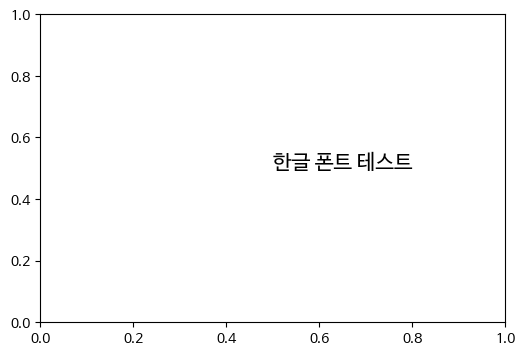

In [1]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.figure(figsize=(6, 4))
plt.text(0.5, 0.5, '한글 폰트 테스트', size=15)
plt.show()

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

### 데이터 불러오기

In [3]:
df = pd.read_csv("/content/data_week3.csv")
df.head()

,unknown1,unknown2,unknown3,unknown4,unknown5,unknown6,unknown7,unknown8,unknown9,unknown10,unknown11,unknown12,unknown13,unknown14,unknown15,unknown16,unknown17,target
0,type3,1486,200,0,0,13,78,888,0.0,16,1,6,8504,5,0,154.0,75,0
1,type2,1350,375,0,0,0,31,2,0.0,0,0,0,19,0,0,44.0,652,0
2,type2,2415,200,0,0,1,2,4,0.0,0,0,0,17,0,0,72.6,412,1
3,type3,7389,200,0,0,0,1,37,0.0,1,0,0,44,0,0,133.3,7,0
4,type3,3954,200,0,0,0,0,71,0.0,0,0,0,217,0,0,133.1,128,0


In [4]:
# Unknown1, 4를 범주형으로 변환
df['unknown1'] = df['unknown1'].astype('category')
df['unknown4'] = df['unknown4'].astype('category')

# 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14094 entries, 0 to 14093
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   unknown1   14094 non-null  category
 1   unknown2   14094 non-null  int64   
 2   unknown3   14094 non-null  int64   
 3   unknown4   14094 non-null  category
 4   unknown5   14094 non-null  int64   
 5   unknown6   14094 non-null  int64   
 6   unknown7   14094 non-null  int64   
 7   unknown8   14094 non-null  int64   
 8   unknown9   14094 non-null  float64 
 9   unknown10  14094 non-null  int64   
 10  unknown11  14094 non-null  int64   
 11  unknown12  14094 non-null  int64   
 12  unknown13  14094 non-null  int64   
 13  unknown14  14094 non-null  int64   
 14  unknown15  14094 non-null  int64   
 15  unknown16  14094 non-null  float64 
 16  unknown17  14094 non-null  int64   
 17  target     14094 non-null  int64   
dtypes: category(2), float64(2), int64(14)
memory usage: 1.7 MB


In [7]:
# 범주형 변수와 숫자형 변수 구분
df_numeric = df.select_dtypes(include='number')
df_category = df.select_dtypes(include= 'category')

In [8]:
# 순서형 범주형 변수
ordinal_cols = ['unknown4']
categorical_cols = ['unknown1', 'unknown4']

# 이산형 변수
discrete_cols = ['unknown4', 'unknown5', 'unknown15']

# 연속형 변수
continuous_cols = ['unknown2', 'unknown3', 'unknown6', 'unknown7', 'unknown8', 'unknown9',
                   'unknown10', 'unknown11', 'unknown12', 'unknown13', 'unknown14',
                   'unknown16', 'unknown17']

### SMOTE 전

In [38]:
df_encoded = pd.get_dummies(df, columns=['unknown1', 'unknown4'])

# 독립 변수와 종속 변수 설정
X = df_encoded.drop(columns=['target'])  # 'target' 열을 제외한 모든 열
y = df_encoded['target']  # 'target' 열

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

from lightgbm import LGBMClassifier
model = LGBMClassifier()
model.fit(X_train, y_train)

from sklearn.metrics import recall_score
y_pred = model.predict(X_test)
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall}')

[LightGBM] [Info] Number of positive: 962, number of negative: 10313
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 11275, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085322 -> initscore=-2.372146
[LightGBM] [Info] Start training from score -2.372146
Recall: 0.016597510373443983


### SMOTE

In [26]:
from collections import Counter

# target 변수의 클래스 분포 확인
print(Counter(df['target']))

Counter({0: 12891, 1: 1203})


#### 1:1 비율

In [27]:
from imblearn.over_sampling import SMOTE

# pandas를 이용한 원-핫 인코딩
df_encoded = pd.get_dummies(df, columns=['unknown1', 'unknown4'])  # 범주형 열만 인코딩

# 특성과 타겟 변수 분리
X = df_encoded.drop('target', axis=1)
y = df_encoded['target']

# SMOTE 적용
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# 오버샘플링 후 클래스 분포 확인
print(Counter(y_res))

Counter({0: 12891, 1: 12891})


* 시각화

<ipython-input-17-874d1f0287e6>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(original_counts.keys()), y=list(original_counts.values()), palette='Blues')
<ipython-input-17-874d1f0287e6>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(resampled_counts.keys()), y=list(resampled_counts.values()), palette='Greens')


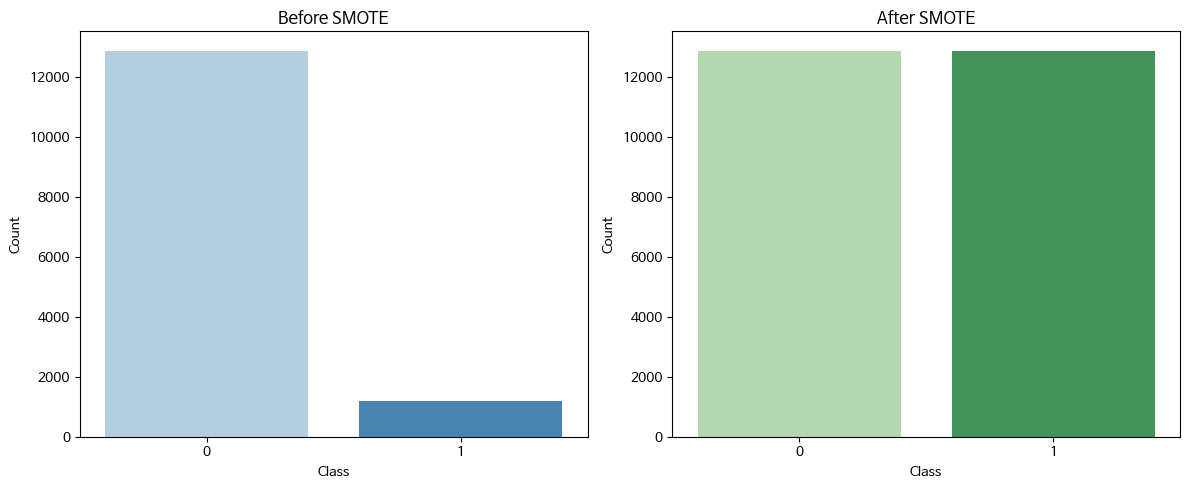

In [17]:
# 샘플링 전 클래스 분포
original_counts = Counter(y)

# 샘플링 후 클래스 분포
resampled_counts = Counter(y_res)

# 그래프 그리기
plt.figure(figsize=(12, 5))

# 첫 번째 그래프: 샘플링 전
plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째 그래프
sns.barplot(x=list(original_counts.keys()), y=list(original_counts.values()), palette='Blues')
plt.title('Before SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')

# 두 번째 그래프: 샘플링 후
plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째 그래프
sns.barplot(x=list(resampled_counts.keys()), y=list(resampled_counts.values()), palette='Greens')
plt.title('After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')

# 그래프 표시
plt.tight_layout()
plt.show()

* 모델링

In [28]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, classification_report

# 학습 및 테스트 데이터 분리 (SMOTE로 생성한 데이터 사용)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# LightGBM 모델 학습
lgb_model = lgb.LGBMClassifier()  # 기본 설정의 LightGBM 분류기 사용
lgb_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred = lgb_model.predict(X_test)

# Recall 계산
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")

[LightGBM] [Info] Number of positive: 10354, number of negative: 10271
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2595
[LightGBM] [Info] Number of data points in the train set: 20625, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502012 -> initscore=0.008049
[LightGBM] [Info] Start training from score 0.008049
Recall: 0.8411509657075286


#### 8:2 비율

In [29]:
from imblearn.over_sampling import SMOTE

# pandas를 이용한 원-핫 인코딩
df_encoded = pd.get_dummies(df, columns=['unknown1', 'unknown4'])  # 범주형 열만 인코딩

# 특성과 타겟 변수 분리
X = df_encoded.drop('target', axis=1)
y = df_encoded['target']

# SMOTE 적용, 소수 클래스 비율을 80%로 설정 (8:2 비율)
smote = SMOTE(sampling_strategy=0.8, random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# 오버샘플링 후 클래스 분포 확인
from collections import Counter
print(Counter(y_res))

Counter({0: 12891, 1: 10312})


* 시각화

<ipython-input-23-874d1f0287e6>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(original_counts.keys()), y=list(original_counts.values()), palette='Blues')
<ipython-input-23-874d1f0287e6>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(resampled_counts.keys()), y=list(resampled_counts.values()), palette='Greens')


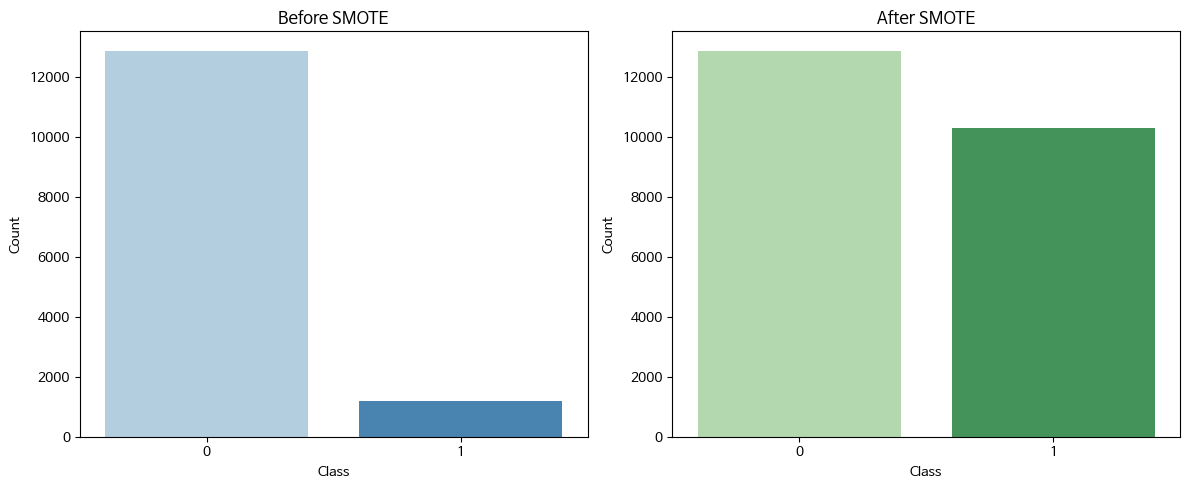

In [23]:
# 샘플링 전 클래스 분포
original_counts = Counter(y)

# 샘플링 후 클래스 분포
resampled_counts = Counter(y_res)

# 그래프 그리기
plt.figure(figsize=(12, 5))

# 첫 번째 그래프: 샘플링 전
plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째 그래프
sns.barplot(x=list(original_counts.keys()), y=list(original_counts.values()), palette='Blues')
plt.title('Before SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')

# 두 번째 그래프: 샘플링 후
plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째 그래프
sns.barplot(x=list(resampled_counts.keys()), y=list(resampled_counts.values()), palette='Greens')
plt.title('After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')

# 그래프 표시
plt.tight_layout()
plt.show()

* 모델링

In [30]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, classification_report

# 학습 및 테스트 데이터 분리 (SMOTE로 생성한 데이터 사용)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# LightGBM 모델 학습
lgb_model = lgb.LGBMClassifier()  # 기본 설정의 LightGBM 분류기 사용
lgb_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred = lgb_model.predict(X_test)

# Recall 계산
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")

[LightGBM] [Info] Number of positive: 8278, number of negative: 10284
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2573
[LightGBM] [Info] Number of data points in the train set: 18562, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.445965 -> initscore=-0.216988
[LightGBM] [Info] Start training from score -0.216988
Recall: 0.7684365781710915


#### 7:3 비율

In [31]:
from imblearn.over_sampling import SMOTE

# pandas를 이용한 원-핫 인코딩
df_encoded = pd.get_dummies(df, columns=['unknown1', 'unknown4'])  # 범주형 열만 인코딩

# 특성과 타겟 변수 분리
X = df_encoded.drop('target', axis=1)
y = df_encoded['target']

# SMOTE 적용, 소수 클래스 비율을 70%로 설정 (7:3 비율)
smote = SMOTE(sampling_strategy=0.7, random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# 오버샘플링 후 클래스 분포 확인
from collections import Counter
print(Counter(y_res))

Counter({0: 12891, 1: 9023})


* 시각화

<ipython-input-19-874d1f0287e6>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(original_counts.keys()), y=list(original_counts.values()), palette='Blues')
<ipython-input-19-874d1f0287e6>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(resampled_counts.keys()), y=list(resampled_counts.values()), palette='Greens')


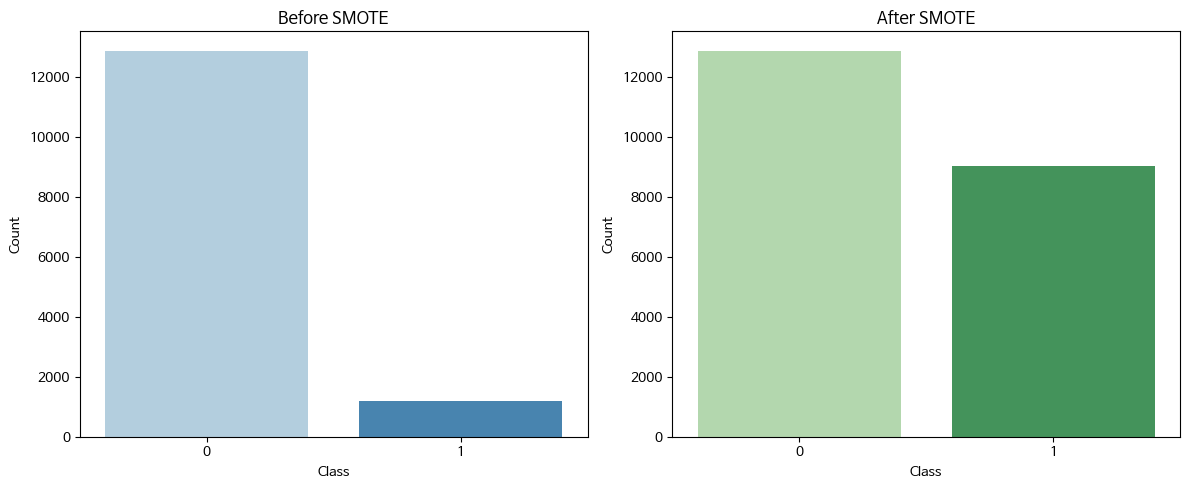

In [19]:
# 샘플링 전 클래스 분포
original_counts = Counter(y)

# 샘플링 후 클래스 분포
resampled_counts = Counter(y_res)

# 그래프 그리기
plt.figure(figsize=(12, 5))

# 첫 번째 그래프: 샘플링 전
plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째 그래프
sns.barplot(x=list(original_counts.keys()), y=list(original_counts.values()), palette='Blues')
plt.title('Before SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')

# 두 번째 그래프: 샘플링 후
plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째 그래프
sns.barplot(x=list(resampled_counts.keys()), y=list(resampled_counts.values()), palette='Greens')
plt.title('After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')

# 그래프 표시
plt.tight_layout()
plt.show()

* 모델링

In [32]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, classification_report

# 학습 및 테스트 데이터 분리 (SMOTE로 생성한 데이터 사용)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# LightGBM 모델 학습
lgb_model = lgb.LGBMClassifier()  # 기본 설정의 LightGBM 분류기 사용
lgb_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred = lgb_model.predict(X_test)

# Recall 계산
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")

[LightGBM] [Info] Number of positive: 7215, number of negative: 10316
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2578
[LightGBM] [Info] Number of data points in the train set: 17531, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.411557 -> initscore=-0.357534
[LightGBM] [Info] Start training from score -0.357534
Recall: 0.7018805309734514


#### 6:4 비율

In [33]:
from imblearn.over_sampling import SMOTE

# pandas를 이용한 원-핫 인코딩
df_encoded = pd.get_dummies(df, columns=['unknown1', 'unknown4'])  # 범주형 열만 인코딩

# 특성과 타겟 변수 분리
X = df_encoded.drop('target', axis=1)
y = df_encoded['target']

# SMOTE 적용, 소수 클래스 비율을 60%로 설정 (6:4 비율)
smote = SMOTE(sampling_strategy=0.6, random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# 오버샘플링 후 클래스 분포 확인
from collections import Counter
print(Counter(y_res))

Counter({0: 12891, 1: 7734})


* 시각화

<ipython-input-21-874d1f0287e6>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(original_counts.keys()), y=list(original_counts.values()), palette='Blues')
<ipython-input-21-874d1f0287e6>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(resampled_counts.keys()), y=list(resampled_counts.values()), palette='Greens')


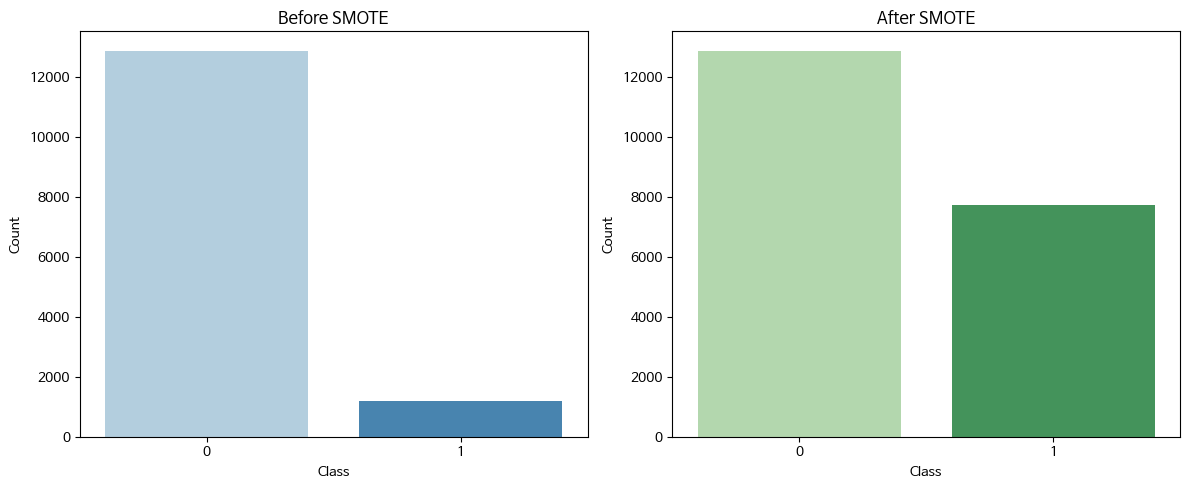

In [21]:
# 샘플링 전 클래스 분포
original_counts = Counter(y)

# 샘플링 후 클래스 분포
resampled_counts = Counter(y_res)

# 그래프 그리기
plt.figure(figsize=(12, 5))

# 첫 번째 그래프: 샘플링 전
plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째 그래프
sns.barplot(x=list(original_counts.keys()), y=list(original_counts.values()), palette='Blues')
plt.title('Before SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')

# 두 번째 그래프: 샘플링 후
plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째 그래프
sns.barplot(x=list(resampled_counts.keys()), y=list(resampled_counts.values()), palette='Greens')
plt.title('After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')

# 그래프 표시
plt.tight_layout()
plt.show()

* 모델링

In [34]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, classification_report

# 학습 및 테스트 데이터 분리 (SMOTE로 생성한 데이터 사용)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# LightGBM 모델 학습
lgb_model = lgb.LGBMClassifier()  # 기본 설정의 LightGBM 분류기 사용
lgb_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred = lgb_model.predict(X_test)

# Recall 계산
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")

[LightGBM] [Info] Number of positive: 6215, number of negative: 10285
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2532
[LightGBM] [Info] Number of data points in the train set: 16500, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376667 -> initscore=-0.503721
[LightGBM] [Info] Start training from score -0.503721
Recall: 0.6510862409479921
